# Xây dựng và tối ưu danh mục đầu tư

#### Cài đặt các thư viện

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Phần 1: Chuẩn bị dữ liệu cổ phiếu S&P 500

#### 1.1 Lấy danh sách các cổ phiếu trong danh mục S&P 500 từ Wikipedia

In [3]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers = tickers.Symbol.to_list()
print(tickers)
print(len(tickers))

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP', 'AES', 'AFL', 'A', 'ABNB', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BBWI', 'BAX', 'BDX', 'WRB', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BG', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CDAY', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'C

#### 1.2 Xác định khoảng thời gian lấy dữ liệu

Lưu ý: Giờ giao dịch tiêu chuẩn của NYSE theo giờ Việt Nam:
* Mùa đông: 21h30 - 4h00 ngày hôm sau;
* Mùa hè: 20h30 - 3h00 ngày hôm sau.

Chỉ lấy dữ liệu sau mốc 4h để đảm bảo đúng thời gian lấy giá đóng cửa phiên giao dịch hôm qua.

Ghi chú: 
* Lấy dữ liệu lúc 4h10 (mùa hè) vẫn chưa có kết quả của phiên trước;
* Lấy dữ liệu lúc 9h00 (mùa hè) vẫn chưa có kết quả của phiên trước;
* Lấy dữ liệu lúc 9h30 (mùa hè) nhận được kết quả của phiên trước;
* Lấy dữ liệu lúc 10h40 (mùa hè) nhận được kết quả của phiên trước.

In [4]:
# Mốc thời gian kết thúc: hôm qua
end_date = datetime.datetime.today() - datetime.timedelta(days=1)
print(end_date)

2023-10-06 18:22:57.638357


In [5]:
# Mốc thời gian bắt đầu: cách hôm qua 730 ngày (3 năm)
start_date = end_date - datetime.timedelta(days=730)
print(start_date)

2021-10-06 18:22:57.638357


#### 1.3 Lấy dữ liệu cổ phiếu từ Yahoo Finance

Ghi chú: Mỗi lần thử lại có số lượng tải thành công khác nhau

Phán đoán: do kết nối Internet

Xử lý: 
* Đảm bảo đường truyền Internet
* Nếu số lượng completed tăng chậm và không đều thì phải tải lại

Lưu ý: 
* Tải các cổ phiếu S&P 500 trong điều kiện đường truyền tốt chỉ có 2 cổ phiếu tải thất bại: BF.B, BRK.B
* Tải các cổ phiếu S&P 100 trong điều kiện đường truyền tốt chỉ có 1 cổ phiếu tải thất bại: BRK.B

In [6]:
# Tải dữ liệu cổ phiếu
stocks_data = yf.download(tickers, start_date, end_date, auto_adjust=True)

[*********************100%%**********************]  503 of 503 completed



2 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2021-10-06 18:22:57.638357 -> 2023-10-06 18:22:57.638357)')


#### 1.4 Tạo ma trận giá cổ phiếu

In [7]:
# Tạo ma trận giá cổ phiếu
price_matrix = stocks_data["Close"]

In [8]:
# Xóa bỏ các cột tồn tại giá trị rỗng (cổ phiếu thiếu dữ liệu)
price_matrix = price_matrix.dropna(axis=1)

In [9]:
print(price_matrix)

                     A        AAL        AAPL        ABBV        ABNB  \
Date                                                                    
2021-10-06  151.601166  20.540001  140.375961  100.923653  167.250000   
2021-10-07  153.248947  20.170000  141.651199  102.354607  169.600006   
2021-10-08  150.436935  20.070000  141.265671  102.640785  169.970001   
2021-10-11  148.019623  20.129999  141.176697  101.865311  166.669998   
2021-10-12  145.977219  20.290001  139.891586  100.231255  172.750000   
...                ...        ...         ...         ...         ...   
2023-10-02  110.900002  12.750000  173.750000  148.250000  136.559998   
2023-10-03  110.260002  12.290000  172.399994  147.429993  127.730003   
2023-10-04  111.669998  12.730000  173.660004  147.690002  127.410004   
2023-10-05  110.349998  12.850000  174.910004  147.449997  124.989998   
2023-10-06  110.639999  12.760000  177.490005  148.240005  126.360001   

                   ABT       ACGL         ACN     

In [10]:
# Số phiên dữ liệu lịch sử
duration = price_matrix.shape[0]
print(duration)

504


#### 1.5 Xây dựng ma trận tỷ suất lợi nhuận theo ngày

In [11]:
# Tạo ma trận 0
return_matrix = pd.DataFrame(0, index=price_matrix.index, columns=price_matrix.columns)

In [12]:
# Tính tỷ lệ giá cổ phiếu giữa hai phiên liên tiếp
for i in range(1, duration):
    return_matrix.iloc[i] = price_matrix.iloc[i] / price_matrix.iloc[i - 1] - 1

In [13]:
print(return_matrix)

                   A       AAL      AAPL      ABBV      ABNB       ABT  \
Date                                                                     
2021-10-06  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2021-10-07  0.010869 -0.018014  0.009084  0.014179  0.014051  0.012190   
2021-10-08 -0.018349 -0.004958 -0.002722  0.002796  0.002182  0.004071   
2021-10-11 -0.016069  0.002990 -0.000630 -0.007555 -0.019415 -0.012754   
2021-10-12 -0.013798  0.007948 -0.009103 -0.016041  0.036479  0.003765   
...              ...       ...       ...       ...       ...       ...   
2023-10-02 -0.006228 -0.004684  0.014836 -0.005434 -0.004737 -0.011564   
2023-10-03 -0.005771 -0.036078 -0.007770 -0.005531 -0.064660  0.000627   
2023-10-04  0.012788  0.035801  0.007309  0.001764 -0.002505 -0.001462   
2023-10-05 -0.011821  0.009427  0.007198 -0.001625 -0.018994  0.005750   
2023-10-06  0.002628 -0.007004  0.014750  0.005358  0.010961  0.007069   

                ACGL       ACN      A

### Phần 2: Lọc các cổ phiếu phù hợp

#### 2.1 Kiểm định tính dừng

Lưu ý: luôn chạy "stationary_stocks = []" để reset trước khi chạy lệnh append để tránh thừa phần từ, nhớ check số lượng

In [14]:
# Tạo danh sách lưu các cổ phiếu thỏa mãn tính dừng
stationary_stocks = []

# Mức ý nghĩa phải <= 0.05
# Mức ý nghĩa càng nhỏ thì kiểm định càng tin cậy
alpha = 0.01

# Kiểm định Dickey–Fuller tăng cường (ADF test)
for column in return_matrix.columns:
    adf_test = adfuller(return_matrix[column])
    p_value = adf_test[1]
    if p_value <= alpha:
        stationary_stocks.append(column)
    else:
        print(column)

print(len(stationary_stocks))

497


In [15]:
return_matrix = return_matrix[stationary_stocks]
print(return_matrix.shape)

(504, 497)


(Kinh nghiệm) chuỗi thời gian tỷ lệ giá của hầu hết các tài sản đầu tư đều thỏa mãn tính dừng

#### 2.2 Kiểm định phân phối nặng đuôi

In [16]:
# Kỳ vọng
means = return_matrix.mean()
print(means)

A      -0.000444
AAL    -0.000485
AAPL    0.000640
ABBV    0.000852
ABNB    0.000020
          ...   
YUM     0.000089
ZBH    -0.000318
ZBRA   -0.001245
ZION   -0.000589
ZTS    -0.000029
Length: 497, dtype: float64


Ghi chú: Kỳ vọng của tỷ suất lợi nhuận xấp xỉ bằng 0 và thường lớn hơn 0 trong dài hạn

In [17]:
# Độ lệch chuẩn
std_devs = return_matrix.std()
print(std_devs)

A       0.019068
AAL     0.030309
AAPL    0.018729
ABBV    0.013316
ABNB    0.033945
          ...   
YUM     0.012950
ZBH     0.016852
ZBRA    0.027069
ZION    0.031516
ZTS     0.017712
Length: 497, dtype: float64


In [18]:
# Tạo series đếm số phần tử
counts = pd.Series([0 for i in range (return_matrix.shape[1])])
print(len(counts))

497


In [19]:
# Số phần tử nằm ngoài về bên trái của khoảng 3 lần độ lệch chuẩn đầu tiên (-inf; mu-3*sigma)
for i in range (len(counts)):
    supremum = means[i] - 3 * std_devs[i]
    for j in range (duration):
        if return_matrix.iloc[j, i] < supremum:
            counts[i] = counts[i] + 1

print(counts)

0      3
1      3
2      3
3      5
4      3
      ..
492    3
493    2
494    4
495    4
496    1
Length: 497, dtype: int64


In [20]:
# Tỷ lệ
ratios = counts / duration
print(ratios)

0      0.005952
1      0.005952
2      0.005952
3      0.009921
4      0.005952
         ...   
492    0.005952
493    0.003968
494    0.007937
495    0.007937
496    0.001984
Length: 497, dtype: float64


Lưu ý: Luôn chạy "std_stocks = []" để reset trước khi chạy lệnh append để tránh gán thừa phần tử

In [21]:
# Kiểm định phân phối nặng đuôi trái
std_stocks = []

# Quy tắc 3 sigma cho đuôi trái: [(100% - 99.73%) / 2]
threshold = 0.00135

for i in range (len(ratios)):
    if ratios[i] <= threshold:
        std_stocks.append(return_matrix.columns[i])

print(std_stocks)
print(len(std_stocks))

['ANSS', 'AOS', 'AVGO', 'BBWI', 'BIIB', 'CDNS', 'DHI', 'DLR', 'FSLR', 'IDXX', 'KLAC', 'LLY', 'LYB', 'MCHP', 'MS', 'NVDA', 'ON', 'PNR', 'SNPS', 'WAB']
20


In [22]:
return_matrix = return_matrix[std_stocks]
print(return_matrix.shape)

(504, 20)


#### 2.3 Kiểm định tổng giá trị giao dịch

In [23]:
# Xác định ma trận giá cho các cổ phiếu lọc ở bước trên
price_matrix = price_matrix[std_stocks]
print(price_matrix)

                  ANSS        AOS        AVGO       BBWI        BIIB  \
Date                                                                   
2021-10-06  344.609985  61.466442  462.184540  60.069679  283.549988   
2021-10-07  348.709991  62.343857  467.044800  61.360054  287.769989   
2021-10-08  345.670013  61.929256  466.033051  61.302273  285.829987   
2021-10-11  344.109985  61.861767  465.550781  60.204494  285.589996   
2021-10-12  343.720001  61.186836  458.874939  61.061531  284.790009   
...                ...        ...         ...        ...         ...   
2023-10-02  297.399994  66.050003  834.950012  33.570000  252.860001   
2023-10-03  287.390015  65.370003  814.830017  32.439999  251.309998   
2023-10-04  290.820007  66.239998  823.809998  32.680000  257.160004   
2023-10-05  290.179993  66.070000  823.859985  32.360001  259.769989   
2023-10-06  296.510010  67.290001  845.260010  32.099998  263.250000   

                  CDNS         DHI         DLR        FSLR     

In [24]:
# Tạo ma trận khối lượng giao dịch
volume_matrix = stocks_data["Volume"]
volume_matrix = volume_matrix[std_stocks]
print(volume_matrix)

              ANSS      AOS     AVGO     BBWI     BIIB     CDNS      DHI  \
Date                                                                       
2021-10-06  245700  1234200  1204200  2695200   978600  1295900  2326900   
2021-10-07  241600  1224000  1326100  2518400   879900  1384700  1691200   
2021-10-08  176800  1223600  1027900  1372700   629600   581300  2119900   
2021-10-11  168100  1474300  1118600  1438500   620600   690000  1994200   
2021-10-12  182400  1786100  2099100  2055400   616200   710800  1829600   
...            ...      ...      ...      ...      ...      ...      ...   
2023-10-02  452200   935300  1467600  3162500   752400   747100  3100900   
2023-10-03  492800   859800  1876100  2509300   830000  1076700  4537100   
2023-10-04  521900   829300  1641700  2368700  1034400   832900  3115800   
2023-10-05  379900  1065400  1147400  2116300   814200   808200  2540400   
2023-10-06  574200  1137400  2109800  2168100  1080100  1415000  2193900   

           

In [25]:
# Tính ma trận tổng khối lượng giao dịch theo phiên
value_matrix = price_matrix * volume_matrix
print(value_matrix)

                    ANSS           AOS          AVGO          BBWI  \
Date                                                                 
2021-10-06  8.467067e+07  7.586188e+07  5.565626e+08  1.618998e+08   
2021-10-07  8.424833e+07  7.630888e+07  6.193481e+08  1.545292e+08   
2021-10-08  6.111446e+07  7.577664e+07  4.790354e+08  8.414963e+07   
2021-10-11  5.784489e+07  9.120280e+07  5.207651e+08  8.660417e+07   
2021-10-12  6.269453e+07  1.092858e+08  9.632244e+08  1.255059e+08   
...                  ...           ...           ...           ...   
2023-10-02  1.344843e+08  6.177657e+07  1.225373e+09  1.061651e+08   
2023-10-03  1.416258e+08  5.620513e+07  1.528703e+09  8.140169e+07   
2023-10-04  1.517790e+08  5.493283e+07  1.352449e+09  7.740912e+07   
2023-10-05  1.102394e+08  7.039098e+07  9.452969e+08  6.848347e+07   
2023-10-06  1.702560e+08  7.653565e+07  1.783330e+09  6.959601e+07   

                    BIIB          CDNS           DHI           DLR  \
Date               

In [26]:
# Tính tổng giá trị giao dịch trong toàn bộ thời gian xét
value_matrix.loc['Total'] = value_matrix.sum()
print(value_matrix)

                             ANSS           AOS          AVGO          BBWI  \
Date                                                                          
2021-10-06 00:00:00  8.467067e+07  7.586188e+07  5.565626e+08  1.618998e+08   
2021-10-07 00:00:00  8.424833e+07  7.630888e+07  6.193481e+08  1.545292e+08   
2021-10-08 00:00:00  6.111446e+07  7.577664e+07  4.790354e+08  8.414963e+07   
2021-10-11 00:00:00  5.784489e+07  9.120280e+07  5.207651e+08  8.660417e+07   
2021-10-12 00:00:00  6.269453e+07  1.092858e+08  9.632244e+08  1.255059e+08   
...                           ...           ...           ...           ...   
2023-10-03 00:00:00  1.416258e+08  5.620513e+07  1.528703e+09  8.140169e+07   
2023-10-04 00:00:00  1.517790e+08  5.493283e+07  1.352449e+09  7.740912e+07   
2023-10-05 00:00:00  1.102394e+08  7.039098e+07  9.452969e+08  6.848347e+07   
2023-10-06 00:00:00  1.702560e+08  7.653565e+07  1.783330e+09  6.959601e+07   
Total                7.257008e+10  3.470752e+10  7.2

In [27]:
# Sắp xếp các cột theo tổng giá trị giao dịch từ bé đến lớn
value_matrix = value_matrix.sort_values(by='Total', axis=1)
print(value_matrix)

                              AOS           PNR           WAB          ANSS  \
Date                                                                          
2021-10-06 00:00:00  7.586188e+07  7.598046e+07  6.705546e+07  8.467067e+07   
2021-10-07 00:00:00  7.630888e+07  9.969589e+07  5.846471e+07  8.424833e+07   
2021-10-08 00:00:00  7.577664e+07  1.487270e+08  5.649695e+07  6.111446e+07   
2021-10-11 00:00:00  9.120280e+07  5.191158e+07  6.691526e+07  5.784489e+07   
2021-10-12 00:00:00  1.092858e+08  6.512121e+07  6.311294e+07  6.269453e+07   
...                           ...           ...           ...           ...   
2023-10-03 00:00:00  5.620513e+07  9.188205e+07  6.234470e+07  1.416258e+08   
2023-10-04 00:00:00  5.493283e+07  7.741010e+07  7.323750e+07  1.517790e+08   
2023-10-05 00:00:00  7.039098e+07  7.798490e+07  1.117791e+08  1.102394e+08   
2023-10-06 00:00:00  7.653565e+07  8.530941e+07  9.332663e+07  1.702560e+08   
Total                3.470752e+10  3.805274e+10  4.4

In [28]:
# Tạo danh sách các cổ phiếu đã sắp xếp
sorted_stocks = value_matrix.columns.tolist()
print(sorted_stocks)

['AOS', 'PNR', 'WAB', 'ANSS', 'BBWI', 'LYB', 'IDXX', 'DLR', 'DHI', 'BIIB', 'CDNS', 'FSLR', 'SNPS', 'MCHP', 'ON', 'KLAC', 'MS', 'LLY', 'AVGO', 'NVDA']


In [29]:
# Lấy ra danh sách 6 cổ phiếu có tổng giá trị giao dịch cao nhất
selected_stocks = sorted_stocks[-6:]
print(selected_stocks)

['ON', 'KLAC', 'MS', 'LLY', 'AVGO', 'NVDA']


In [30]:
return_matrix = return_matrix[selected_stocks]
print(return_matrix.shape)

(504, 6)


#### 2.4 Phân tích khám phá dữ liệu

In [31]:
# Thống kê mô tả
return_matrix.describe()

,ON,KLAC,MS,LLY,AVGO,NVDA
count,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,0.001965,0.001107,-0.000121,0.002006,0.001429,0.002247
std,0.033457,0.026849,0.018016,0.017634,0.021604,0.036955
min,-0.089656,-0.075733,-0.050906,-0.044532,-0.061794,-0.094726
25%,-0.020151,-0.015650,-0.010650,-0.007943,-0.011811,-0.020684
50%,0.002490,-0.000432,-0.000539,0.001767,0.000277,0.001501
75%,0.022787,0.018861,0.010845,0.010703,0.013176,0.021755
max,0.143957,0.091047,0.064490,0.148696,0.115162,0.243696


array([[<Axes: title={'center': 'ON'}>, <Axes: title={'center': 'KLAC'}>],
       [<Axes: title={'center': 'MS'}>, <Axes: title={'center': 'LLY'}>],
       [<Axes: title={'center': 'AVGO'}>,
        <Axes: title={'center': 'NVDA'}>]], dtype=object)

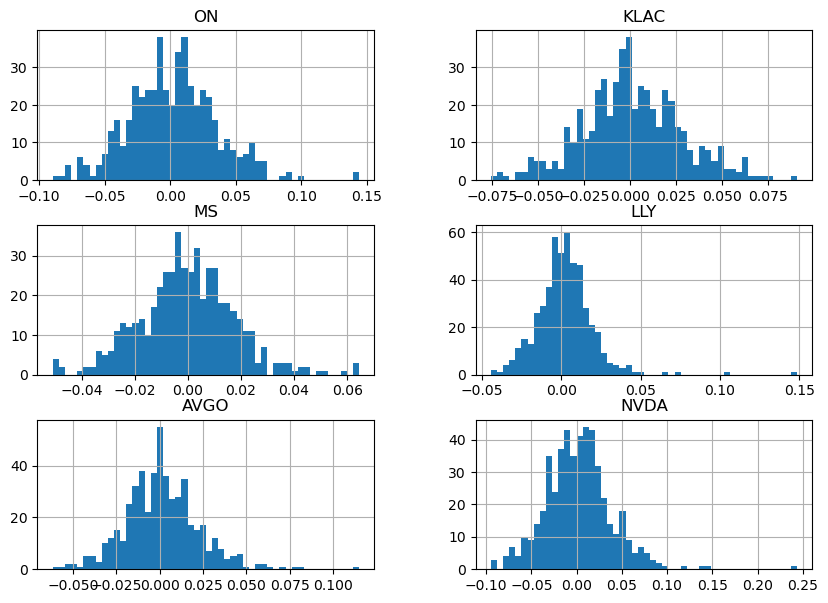

In [32]:
# Biểu đồ hist
return_matrix.hist(bins=50, figsize=(10, 7))

In [33]:
# Ma trận tương quan
correlation_matrix = return_matrix.corr()
print(correlation_matrix)

            ON      KLAC        MS       LLY      AVGO      NVDA
ON    1.000000  0.794524  0.526150  0.128549  0.712445  0.723975
KLAC  0.794524  1.000000  0.532745  0.202964  0.744591  0.761587
MS    0.526150  0.532745  1.000000  0.162937  0.503434  0.517001
LLY   0.128549  0.202964  0.162937  1.000000  0.212681  0.171956
AVGO  0.712445  0.744591  0.503434  0.212681  1.000000  0.711806
NVDA  0.723975  0.761587  0.517001  0.171956  0.711806  1.000000


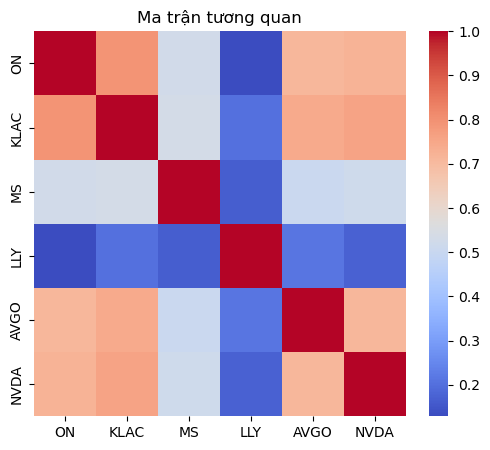

In [34]:
# Trực quan hóa
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Ma trận tương quan')
plt.show()

### Phần 3: Tối ưu thử nghiệm ngày liền trước ngày hôm qua & xác định best_TW cho tương lai gần

##### Bước 1: Tạo ma trận tỷ lệ giá theo phiên

In [35]:
ratio_matrix = return_matrix[selected_stocks] + 1
ratio_matrix = np.array(ratio_matrix)
print(ratio_matrix)
print(ratio_matrix.shape)

[[1.         1.         1.         1.         1.         1.        ]
 [1.01543621 1.00303849 0.99697274 1.02339235 1.01051584 1.01811601]
 [0.97995153 0.98773096 1.01255056 1.00325949 0.99783372 0.98842231]
 ...
 [1.00256234 1.0203833  1.01371443 1.01193857 1.01102068 1.01204125]
 [0.97977553 1.00006507 1.0007587  1.01885364 1.00006068 1.01469086]
 [1.03130319 1.01511669 1.01490841 1.04384278 1.02597532 1.02403328]]
(504, 6)


In [36]:
# Thêm cột tiền mặt
cash = np.ones((duration, 1))

ratio_matrix = np.c_[ratio_matrix, cash]
print(ratio_matrix)

[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.01543621 1.00303849 0.99697274 ... 1.01051584 1.01811601 1.        ]
 [0.97995153 0.98773096 1.01255056 ... 0.99783372 0.98842231 1.        ]
 ...
 [1.00256234 1.0203833  1.01371443 ... 1.01102068 1.01204125 1.        ]
 [0.97977553 1.00006507 1.0007587  ... 1.00006068 1.01469086 1.        ]
 [1.03130319 1.01511669 1.01490841 ... 1.02597532 1.02403328 1.        ]]


#### Xét TW = 5

In [37]:
TW = 5

##### Bước 2: Xây dựng ma trận con dựa trên TW

In [38]:
# Không tính ma trận con trước ma trận con gần đây vì tại thời điểm xét chưa có dữ liệu giá của ngày next2
sub_matrices_number = ((duration - 2) - TW + 1) - 1
print(sub_matrices_number)

497


Lưu ý: luôn chạy lệnh khởi tạo "= []" để reset trước khi tiến hành lệnh "append" để tránh thừa dữ liệu

In [39]:
# Tạo danh sách chứa các ma trận con
sub_matrices = []

for i in range(sub_matrices_number + 1):
    # Loại bỏ ma trận trước ma trận con gần đây vì không có dữ liệu của ngày next2
    if i == sub_matrices_number - 1:
        continue
    sub_matrix = ratio_matrix[i : i + TW]
    sub_matrices.append(sub_matrix)

print(len(sub_matrices))

497


In [40]:
# Tạo danh sách chứa mảng giá của ngày liền sau ngày kế tiếp của TW
train_next2_days = []

for i in range(sub_matrices_number - 1):
    train_next2_day = ratio_matrix[i + TW + 1]
    train_next2_days.append(train_next2_day)

print(len(train_next2_days))

496


##### Bước 3: Biến đổi các ma trận con thành dạng vector

In [41]:
# Tạo danh sách chứa các vector
train_vectors = []

# Biến đổi các ma trận con thành dạng vector
for sub_matrix in sub_matrices:
    vector = sub_matrix.flatten()
    train_vectors.append(vector)

print(len(train_vectors))

497


In [42]:
# Vector gần đây
recent_vector = train_vectors[-1]
print(recent_vector)
print(recent_vector.shape)

[1.02172732 1.02812191 1.00661361 0.99034124 1.01859674 1.01462283
 1.         0.98830403 1.00124431 0.99367314 0.98655523 0.99829329
 1.00951513 1.         1.00451862 1.00429512 0.98457213 1.00215958
 1.00526138 1.02949497 1.         0.96133661 0.98091742 0.97027724
 0.97566372 0.97590275 0.97175206 1.         1.00256234 1.0203833
 1.01371443 1.01193857 1.01102068 1.01204125 1.        ]
(35,)


##### Bước 4: Phân cụm các vector

In [43]:
# Số cụm tối đa
max_K = int(np.sqrt(sub_matrices_number))

# Số lần chạy lại thuật toán KMeans
q_number = 10

# Chỉ số silhouete cao nhất
silhouette_max = 0

# Số cụm tối ưu
optimal_K = 0

for K in range(2, max_K + 1):
    kmeans = KMeans(n_clusters=K)
    silhouette_index = 0
    for q in range (q_number):
        kmeans.fit(train_vectors)
        silhouette_q = silhouette_score(train_vectors, kmeans.labels_)
        silhouette_index = silhouette_index + silhouette_q
    silhouette_index = silhouette_index / q_number
    if silhouette_index > silhouette_max:
        silhouette_max = silhouette_index
        optimal_K = K

print("Với TW = {} thì số cụm tối ưu là K = {}, đạt được chỉ số silhouette = {}".format(TW, optimal_K, silhouette_max))


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

Với TW = 5 thì số cụm tối ưu là K = 5, đạt được chỉ số silhouette = 0.09759130240376718


##### Bước 5: Xác định mẫu tương đồng

In [44]:
# Chọn số cụm là số cụm tối ưu ở bước trước
kmeans = KMeans(n_clusters=optimal_K)

# Tăng số lần lặp lên 30 để tăng độ chính xác
z_number = 30

# Tạo danh sách chứa số lần vector huấn luyện cùng cụm với vector gần đây
same_cluster_count = [0] * (sub_matrices_number - 1)

for z in range(z_number):
    kmeans.fit(train_vectors)
    labels = kmeans.labels_
    for i in range(sub_matrices_number - 1):
        if labels[i] == labels[-1]:
            same_cluster_count[i] = same_cluster_count[i] + 1

print(same_cluster_count)
print(len(same_cluster_count))

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

[0, 30, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 29, 0, 0, 0, 0, 0, 2, 7, 0, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 3, 26, 0, 0, 0, 0, 30, 27, 0, 0, 0, 0, 30, 0, 0, 0, 30, 0, 0, 0, 0, 29, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 30, 0, 14, 30, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 16, 30, 0, 0, 0, 0, 0, 0, 29, 0, 30, 0, 30, 0, 0, 0, 0, 0, 0, 30, 0, 30, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 30, 0, 26, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 30, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 0, 30, 30, 0, 0, 0, 0, 30, 0, 0, 0, 0, 30, 0, 0, 0, 0, 30, 0, 30, 0, 0, 0, 30, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 0, 0, 30, 30, 7, 0, 0, 0, 11, 30, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 30, 28, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 0, 0, 30, 30, 0, 30, 0, 0, 0, 0, 30, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 21, 0, 30, 30, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 30, 0, 

In [45]:
# Tạo danh sách chứa chỉ số của các vector tương đồng với vector gần đây
similar_vectors_indices = []

for i in range(sub_matrices_number - 1):
    if same_cluster_count[i] >= z_number * 0.8:
        similar_vectors_indices.append(i)

print(similar_vectors_indices)
print(len(similar_vectors_indices))

[1, 6, 21, 31, 37, 43, 49, 56, 61, 70, 80, 86, 91, 92, 97, 101, 106, 111, 117, 120, 134, 141, 143, 145, 152, 154, 165, 167, 168, 180, 181, 188, 196, 197, 202, 207, 212, 214, 218, 223, 232, 233, 239, 250, 251, 252, 263, 268, 277, 278, 280, 285, 290, 298, 299, 305, 310, 315, 316, 325, 332, 336, 341, 342, 347, 360, 362, 372, 373, 378, 384, 393, 397, 406, 411, 412, 415, 422, 423, 424, 435, 445, 446, 454, 455, 460, 465, 470, 476, 478, 480]
91


##### Bước 6: Dự đoán tỷ lệ giá của ngày hôm sau

In [46]:
# Tạo danh sách chứa độ tương tự cosin của các vector huấn luyện với vector gần đây
cos_similarities = []

for vector_index in similar_vectors_indices:
    cos = (train_vectors[vector_index] @ recent_vector) / (np.linalg.norm(train_vectors[vector_index]) * np.linalg.norm(recent_vector))
    cos_similarities.append(cos)

print(cos_similarities)
print(len(cos_similarities))

[0.9998712450417854, 0.9998286613751417, 0.9996103693116287, 0.999664991342817, 0.9996281784066817, 0.9993586948057596, 0.999387861408576, 0.9998712944631534, 0.9994842437829977, 0.9995290290579513, 0.9997605792213234, 0.9996498730441092, 0.999445485165502, 0.999653812296221, 0.99976619864014, 0.9997058922666309, 0.9996750782907511, 0.9998079224766309, 0.9995833847185268, 0.9998326461800459, 0.9997605248805279, 0.9995453727476303, 0.9997392100016074, 0.9995673965518931, 0.9995281573238387, 0.9995136136235803, 0.9996026811735449, 0.9996619910722084, 0.9996357799101585, 0.9995997739475478, 0.999605489794763, 0.9996702670110985, 0.9998294711284496, 0.9997182679912998, 0.9997683172183595, 0.9996357194959207, 0.999745519394055, 0.9997879241858558, 0.9995649967102312, 0.9995645057957546, 0.999814327370488, 0.9993948806665313, 0.9997933106715451, 0.9996138827413296, 0.9995827213839539, 0.9996271961050346, 0.9997811077356165, 0.9997296015665253, 0.999082406396467, 0.9998692791519727, 0.9997313

Do chênh lệch giữa các độ tương tự cosin quá nhỏ nên dùng hàm mũ để gia tăng tỷ lệ cách biệt

In [47]:
similarities = np.array(cos_similarities)**64
print(similarities)

[0.99179301 0.9890933  0.97536724 0.97878414 0.97648    0.95977471
 0.96156908 0.99179615 0.9675222  0.97030071 0.98479206 0.97783724
 0.9651239  0.97808388 0.98514638 0.98135043 0.97941643 0.98778112
 0.97368354 0.98934562 0.98478864 0.97131665 0.98344582 0.97268731
 0.97024656 0.96934344 0.97488725 0.97859616 0.97695535 0.9747058
 0.97506257 0.97911479 0.98914457 0.98212824 0.98528    0.97695157
 0.98384311 0.98651742 0.97253787 0.9725073  0.98818619 0.96200141
 0.98685764 0.97558667 0.97364219 0.97641859 0.98608705 0.98284108
 0.94293969 0.99166822 0.98295135 0.99224356 0.98183684 0.98664442
 0.97865995 0.98211322 0.98031898 0.98658807 0.98711532 0.97459215
 0.98124579 0.99155424 0.98248233 0.99203177 0.97725523 0.98911792
 0.9837249  0.99032843 0.98896803 0.98602016 0.98401233 0.97962306
 0.98337953 0.98890491 0.93507213 0.96520598 0.9806104  0.98826874
 0.98861464 0.9845702  0.98814481 0.98411315 0.97627102 0.99294239
 0.98383838 0.9577327  0.9885393  0.98777458 0.99030706 0.98520

In [48]:
# Tính tổng các độ tương tự
sum_similarities = np.sum(similarities)
print(sum_similarities)

89.18475626968504


In [49]:
# Tạo vector trọng số của mỗi vector
w = np.array(similarities) / sum_similarities
w = w.reshape(-1, 1)
print(w.shape)

(91, 1)


In [50]:
# Tạo ma trận tỷ lệ giá từ các vector tương đồng với vector gần đây
C = []

for vector_index in similar_vectors_indices:
    C.append(train_next2_days[vector_index])

C = np.array(C)
print(C.shape)

(91, 7)


In [51]:
# Tỷ lệ giá dự đoán
predict = w.T @ C
print(predict)

[[1.00610883 1.0022386  1.00224129 1.00406614 1.00485277 1.00803967
  1.        ]]


##### Bước 7: Tối ưu danh mục đầu tư

In [52]:
temp_opt_portfolio = np.full(predict.shape[1] - 1, None)

for i in range(predict.shape[1] - 1):
    if predict[0, i] > 0:
        temp_opt_portfolio[i] = predict[0, i] - 1

# Nếu tất cả cổ phiếu dự đoán âm thì full cash
if np.all(temp_opt_portfolio < 0):
    opt_portfolio = np.zeros(predict.shape[1])
    opt_portfolio[-1] = 1

# Nếu tất cả bằng 0 thì không thay đổi danh mục hôm liền trước
elif np.all(temp_opt_portfolio == 0):
    pass

# Nếu 1 trong các phần tử lớn hơn 0:
else:
    opt_portfolio = np.append(temp_opt_portfolio, 0)
    opt_portfolio = opt_portfolio / np.sum(opt_portfolio)

print(opt_portfolio)

[0.22175775442693302 0.08126401300445356 0.08136147406306145
 0.14760568840225102 0.17616149852087293 0.291849571582428 0.0]


In [53]:
# Tạo ma trận lưu các mảng opt_portfolio theo TW
opt_TW_matrix = np.array([opt_portfolio])
print(opt_TW_matrix)

[[0.22175775442693302 0.08126401300445356 0.08136147406306145
  0.14760568840225102 0.17616149852087293 0.291849571582428 0.0]]


#### Xét TW từ 6 đến 10

In [54]:
for TW in range(6, 11):
    # Bước 2: Xây dựng ma trận con dựa trên TW
    # Không tính ma trận con trước ma trận con gần đây vì tại thời điểm xét chưa có dữ liệu giá của ngày next2
    sub_matrices_number = ((duration - 2) - TW + 1) - 1
    print(sub_matrices_number)